# Shapelet Discovery

In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import stumpy
import os
os.environ["NUMBA_NUM_THREADS"] = "24"
os.environ["OMP_NUM_THREADS"]="24"

In [124]:
#short_ts = np.random.rand(2**12)
#long_ts = np.random.rand(2**20) 

In [125]:
#start = time.time()
#mp = stumpy.gpu_stump(short_ts, 50, ignore_trivial=True)
#print(time.time()-start)

In [126]:
train = pd.read_csv("labelled_training_data.csv")

In [127]:
testing = pd.read_csv("labelled_testing_data.csv")
val = pd.read_csv("labelled_validation_data.csv")

In [128]:
data = pd.concat([train, testing, val])

In [129]:
data = data.sort_values(by=['timestamp'])

In [130]:
data = data.set_index("timestamp")

In [131]:
data.head()

,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
timestamp,,,,,,,,,,,,,,,
124.439221,381,381,1,101,4026532232,systemd-resolve,ip-10-100-1-129,41,socket,"[139913106282763, 139913103116537, 94901962555...",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
124.439751,378,378,1,100,4026532231,systemd-network,ip-10-100-1-129,41,socket,"[140343254628619, 93967981149065, 93967990898192]",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
124.439958,1,1,0,0,4026531840,systemd,ip-10-100-1-129,1005,security_file_open,"[140074839310116, 8103505641674583864]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
124.440007,1,1,0,0,4026531840,systemd,ip-10-100-1-129,257,openat,[],4,12,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
124.440037,1,1,0,0,4026531840,systemd,ip-10-100-1-129,5,fstat,[140074839307913],2,0,"[{'name': 'fd', 'type': 'int', 'value': 12}, {...",0,0


In [132]:
data.shape

(1141078, 15)

In [133]:
data["processId"] = data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
data["parentProcessId"] = data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
data["userId"] = data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
data["mountNamespace"] = data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
data["eventId"] = data["eventId"]  # Keep eventId values (requires knowing max value)
data["returnValue"] = data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

In [134]:
data["eventId"].unique()

array([  41, 1005,  257,    5,    3, 1006,   87, 1003,  114,  113,   42,
         51,  288,   21, 1010,   49,    6,  217,    4,   56,   91,  157,
         62,  292,   33,   59, 1004,  263,  166,   43,   32,  106,  105,
         88,  165,   94,  133,  260,   90,  321,  319,   50,  269,  123,
        122,    2], dtype=int64)

In [135]:
 #from sklearn.preprocessing import MinMaxScaler

In [136]:
#scaler = MinMaxScaler(feature_range=(0,1))

In [137]:
#old_shape = data['eventId'].shape

In [138]:
#data['eventId'] = scaler.fit_transform(data['eventId'].to_numpy().reshape(-1,1)).reshape(old_shape)

In [139]:
#data['eventId'].unique()

In [140]:
dataset = data[['processId', 'parentProcessId','userId','mountNamespace','eventId','argsNum','returnValue', 'sus']]

In [141]:
dataset.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus
timestamp,,,,,,,,
124.439221,1,0,0,1,41,3,1,0
124.439751,1,0,0,1,41,3,1,0
124.439958,0,0,0,0,1005,4,0,0
124.440007,0,0,0,0,257,4,1,0
124.440037,0,0,0,0,5,2,0,0


In [142]:
dataset.isna().sum()

processId          0
parentProcessId    0
userId             0
mountNamespace     0
eventId            0
argsNum            0
returnValue        0
sus                0
dtype: int64

In [143]:
dataset['sus'].value_counts()

sus
0    967564
1    173514
Name: count, dtype: int64

In [144]:
#dataset = dataset.reset_index()

In [145]:
#bins = pd.cut(dataset['timestamp'], bins=10000)
#event_counts_notsus = dataset[dataset['sus']==0].groupby(bins).size()
#event_counts_sus = dataset[dataset['sus']==1].groupby(bins).size()
#event_counts_notsus.plot(kind='line', color='blue', label='Not Suspicious', figsize=(12, 4))
#event_counts_sus.plot(kind='line', color='red', label='Suspicious')
#plt.xlabel('Timestamp')
#plt.ylabel('Event Frequency')
#plt.title('Event Frequency')
#plt.xticks([])
#plt.legend()
#plt.show()

In [146]:
#This function takes a pandas DataFrame `df` as input and returns a modified version of it. 
#The function first creates a new column called `separator` with only NaN values using the `assign()` method. 
#It then stacks the DataFrame, which essentially transforms the columns into rows, and converts the resulting Series object back into a DataFrame with the correct formatting using the `stack()` and `to_frame()` methods. 
#Finally, it resets the index and renames the column containing the stacked values to "centroid" using the `reset_index()`, `rename()` and `drop=True` methods. 
#Overall, this function goal is to flattening the DataFrame `df` and combining its values into a single column called "centroid", with NaN values added as separators between the original columns.
def merge_sequences(df):
    return df.assign(
        # create a new col called separator with only NaNs
        separator=np.nan
        # create a stack series and convert it back into a dataframe with the cxorrect formatting
        ).stack(dropna=False).to_frame().reset_index(drop=True).rename({0: "centroid"}, axis=1)

In [147]:
sus = merge_sequences(dataset[dataset['sus']==1])

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_1992\1375280662.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return df.assign(


In [148]:
notsus = merge_sequences(dataset[dataset['sus']==0])

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_1992\1375280662.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return df.assign(


In [149]:
#fig, ax = plt.subplots(2,figsize=(24,8),sharex=True)
#ax[0].set_title('OS')
#ax[0].plot(OS)
#ax[1].set_title('Not_OS')
#ax[1].plot(Not_OS)

In [150]:
sus.head()

,centroid
0,1.0
1,1.0
2,1.0
3,0.0
4,3.0


In [151]:
sus.isna().sum()

centroid    173514
dtype: int64

In [152]:
sus['centroid'] = sus['centroid'].fillna(sus['centroid'].mean())

In [153]:
sus.isna().sum()

centroid    0
dtype: int64

In [154]:
notsus.isna().sum()

centroid    967564
dtype: int64

In [155]:
notsus['centroid'] = notsus['centroid'].fillna(notsus['centroid'].mean())

In [156]:
notsus.isna().sum()

centroid    0
dtype: int64

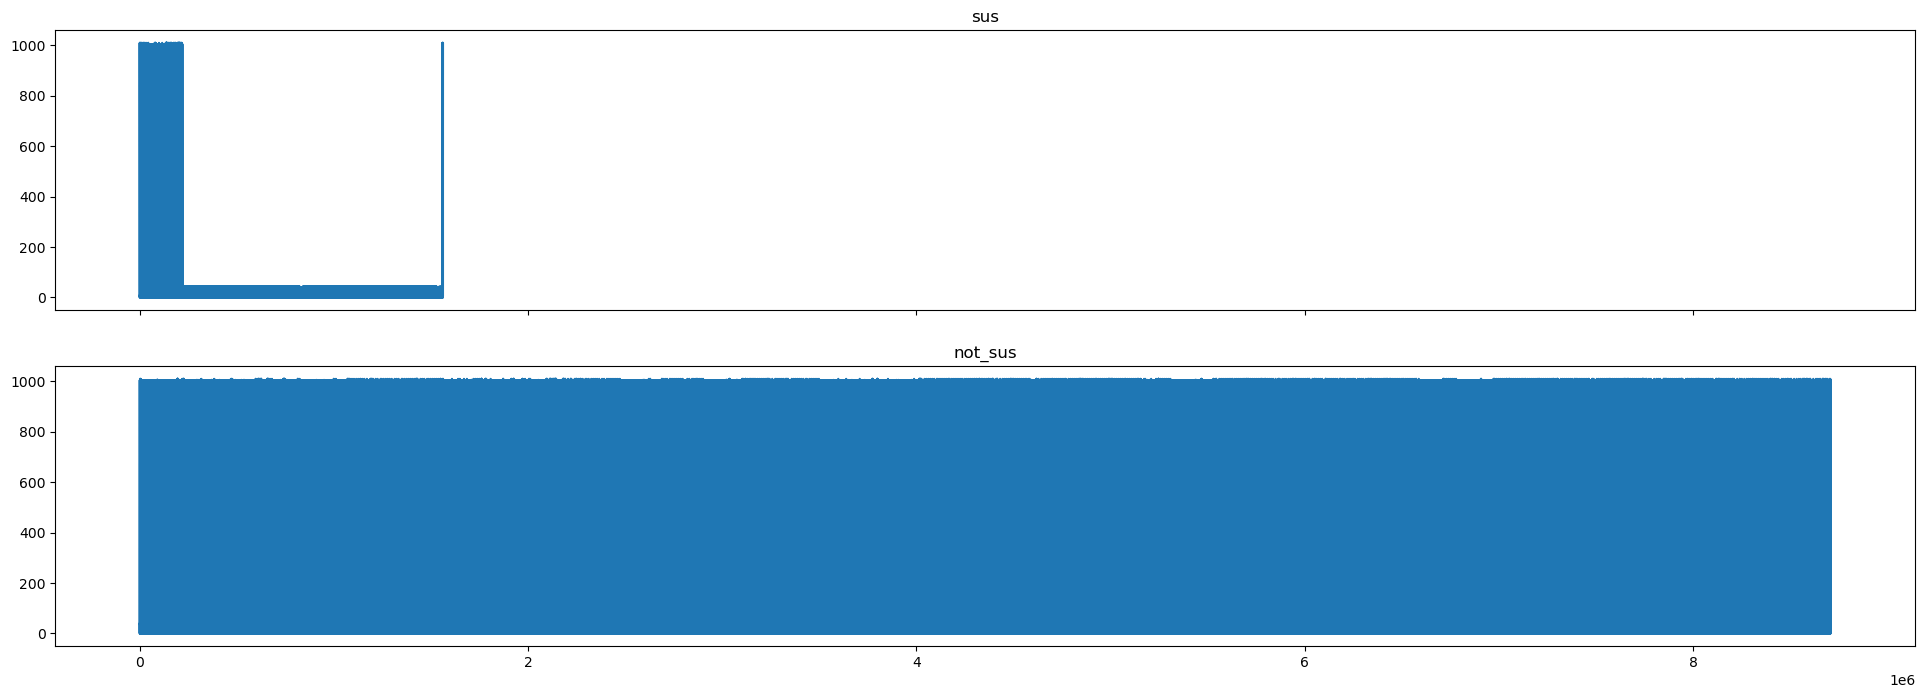

In [157]:
fig, ax = plt.subplots(2,figsize=(24, 8), sharex=True)

ax[0].set_title('sus')
ax[0].plot(sus)

ax[1].set_title('not_sus')
ax[1].plot(notsus)

In [ ]:
#In this code snippet, a variable `m` is defined with a value of 100000. 
#Then, the `gpu_stump()` function from the STUMPY library is used to compute the matrix profile for the time series data `sus['centroid']` with a window size of `m`. The `[:, 0]` indexing is used to extract the first column of the resulting matrix profile. 
#Finally, the extracted matrix profile is cast to a float data type using the `astype(float)` method and assigned to the variable `profile_sus_sus`

In [158]:
m = 100000
profile_sus_sus = stumpy.gpu_stump(sus['centroid'], m)[:, 0].astype(float)

In [159]:
profile_sus_notsus = stumpy.gpu_stump(sus['centroid'].astype(float), m, notsus['centroid'].astype(float), ignore_trivial=False)[:, 0].astype(float)

In [160]:
import seaborn as sns

C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

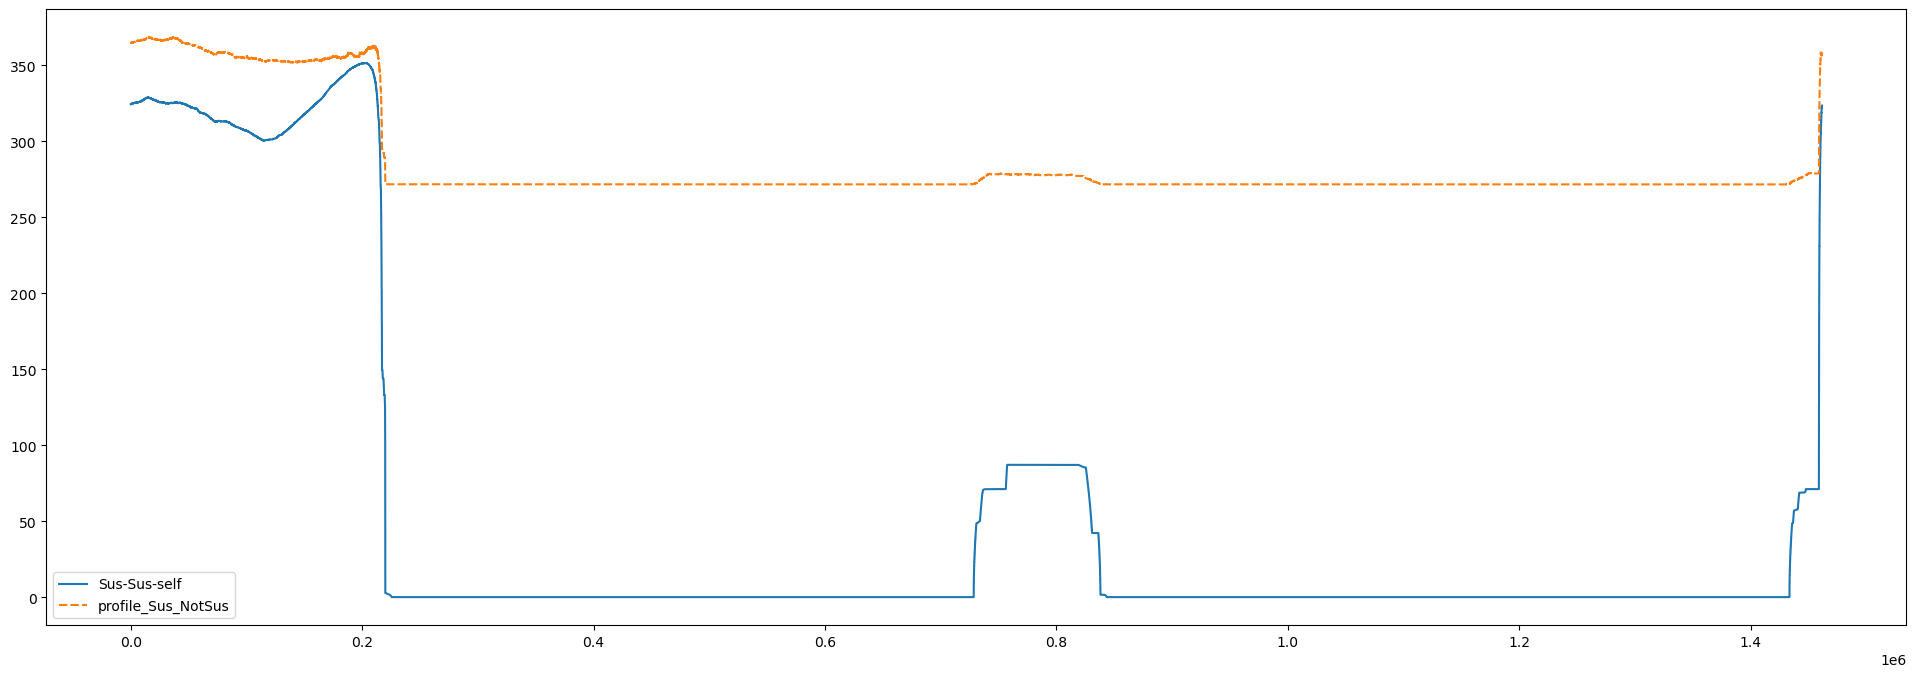

In [161]:
fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data={'Sus-Sus-self':profile_sus_sus,'profile_Sus_NotSus':profile_sus_notsus}, ax=ax)

In [162]:
profile_diff = profile_sus_notsus - profile_sus_sus

In [163]:
profile_diff

array([40.24393338, 40.24393198, 40.24393519, ..., 35.22554293,
       35.22555955, 35.22552718])

In [164]:
worst_matches = np.argpartition(profile_diff,-10)[-10:]

In [165]:
worst_matches

array([ 728478, 1433619, 1433618, 1433620, 1433622, 1433623,  728477,
        728482,  728481,  728479], dtype=int64)

In [166]:
#The code snippet provided is creating two empty lists, `sus_shapelets` and `notsus_shapelets`. 
#It then iterates over the `worst_matches` list and extracts a shapelet from the `sus` dictionary using the indices from `worst_matches`. 
#The extracted shapelet is then appended to the `sus_shapelets` list.

sus_shapelets = []
notsus_shapelets = []

for idx in worst_matches:
    sus_shapelet = sus['centroid'][idx:idx+m]    
    sus_shapelets.append(sus_shapelet)

# Building a Shapelet Based Model

In [167]:
from sklearn.model_selection import train_test_split

In [221]:
dataset.shape

(1141078, 8)

In [222]:
X = dataset[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]

In [223]:
y = dataset['sus']

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#The function computes the mass distance profile, which is an array representing the distances between the query subsequence and all possible subsequence windows of the time series.
#Each value in the mass distance profile corresponds to the distance between the query subsequence and a specific subsequence window of the time series.
#The mass distance is calculated using the MASS (Mean Absolute Subsequence Similarity) algorithm, which efficiently computes the Euclidean distance between the query subsequence and each subsequence window. 
#The algorithm utilizes the Fast Fourier Transform (FFT) to speed up the computation.

In [173]:
def get_shapelet_distance(shapelet, train):
    X = []
    for s, sample in enumerate(train):
        D = stumpy.mass(shapelet, sample)
        X.append(D.min())
    
    return np.array(X).reshape(-1,1)

In [174]:
X_train.values.astype('float64').shape

(764522, 7)

In [175]:
sus_shapelets[0].values

array([1.        , 1.        , 1.        , ..., 1.        , 9.59625664,
       1.        ])

In [176]:
len(X_train)

764522

In [177]:
X_train.values

array([[   1,    1,    0, ...,    5,    2,    0],
       [   1,    1,    0, ...,    3,    1,    0],
       [   1,    1,    0, ..., 1005,    4,    0],
       ...,
       [   1,    1,    0, ..., 1005,    4,    0],
       [   1,    1,    0, ..., 1005,    4,    0],
       [   1,    1,    0, ..., 1005,    4,    0]], dtype=int64)

In [178]:
reference_shapelet = sus_shapelets[0].values

In [179]:
reference_shapelet = reference_shapelet[0:4]

In [180]:
X_train_dist = get_shapelet_distance(reference_shapelet, X_train.values.astype('float64'))

In [181]:
X_test_dist = get_shapelet_distance(reference_shapelet, X_test.values.astype('float64'))

In [182]:
from sklearn.tree import DecisionTreeClassifier

In [183]:
model = DecisionTreeClassifier()

model.fit(X_train_dist, y_train)

DecisionTreeClassifier()

In [184]:
from sklearn.metrics import accuracy_score

In [185]:
y_pred = model.predict(X_test_dist)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.9861481426401385

In [216]:
prediction_threshold = np.where(y_pred>0.5,1,0)

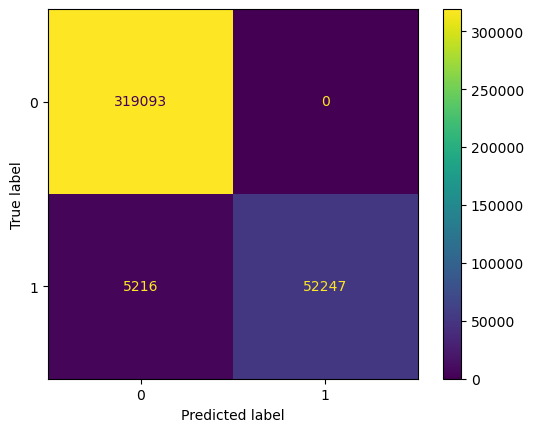

In [225]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction_threshold)
ConfusionMatrixDisplay(conf_matrix).plot()

In [226]:
print(classification_report(y_test, prediction_threshold))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    319093
           1       1.00      0.91      0.95     57463

    accuracy                           0.99    376556
   macro avg       0.99      0.95      0.97    376556
weighted avg       0.99      0.99      0.99    376556



# Long Short Term Memory Network

In [186]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import tensorflow as tf
from keras.layers import Flatten, Dense, Input, Dropout, Conv1D, BatchNormalization, MaxPooling1D, Flatten, LSTM, Bidirectional, Embedding, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adamax

In [187]:
random_normal_initializer = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.1, seed=51)
model1 = Sequential([
  LSTM(32, input_shape=(1, 1), activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  Flatten(),
  Dense(units=128, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dense(units=1, activation='sigmoid', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer)
])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 32)             4352      
                                                                 
 dropout_8 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_5 (LSTM)               (None, 1, 32)             8320      
                                                                 
 dropout_9 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 32)             8320      
                                                                 
 dropout_10 (Dropout)        (None, 1, 32)             0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 32)            

In [188]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

In [190]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [191]:
X_train_distLSTM = get_shapelet_distance(reference_shapelet, X_train.values.astype('float64'))

In [192]:
X_test_distLSTM   = get_shapelet_distance(reference_shapelet, X_test.values.astype('float64'))

In [193]:
X_val_distLSTM  = get_shapelet_distance(reference_shapelet, X_val.values.astype('float64'))

In [194]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False)
history1 = model1.fit(X_train_distLSTM,y_train, validation_data=(X_val_distLSTM, y_val), epochs=100, verbose=1, batch_size=10000,callbacks=[callback])

Epoch 1/100
86/86 [==============================] - 6s 32ms/step - loss: 0.4172 - accuracy: 0.8193 - val_loss: 0.2210 - val_accuracy: 0.8484
Epoch 2/100
86/86 [==============================] - 2s 23ms/step - loss: 0.1815 - accuracy: 0.9142 - val_loss: 0.1290 - val_accuracy: 0.9858
Epoch 3/100
86/86 [==============================] - 2s 29ms/step - loss: 0.0898 - accuracy: 0.9860 - val_loss: 0.0783 - val_accuracy: 0.9858
Epoch 4/100
86/86 [==============================] - 3s 39ms/step - loss: 0.0732 - accuracy: 0.9860 - val_loss: 0.0805 - val_accuracy: 0.9858
Epoch 5/100
86/86 [==============================] - 2s 28ms/step - loss: 0.0727 - accuracy: 0.9860 - val_loss: 0.0765 - val_accuracy: 0.9858
Epoch 6/100
86/86 [==============================] - 2s 28ms/step - loss: 0.0722 - accuracy: 0.9860 - val_loss: 0.0756 - val_accuracy: 0.9858
Epoch 7/100
86/86 [==============================] - 3s 29ms/step - loss: 0.0720 - accuracy: 0.9860 - val_loss: 0.0775 - val_accuracy: 0.9858


In [195]:
# Model evaluation
accuracy1 = model1.evaluate(X_test_distLSTM,y_test)
print(f"Accuracy of model1: {(100*accuracy1[1]):.1f}%")

3566/3566 [==============================] - 5s 2ms/step - loss: 0.0765 - accuracy: 0.9861
Accuracy of model1: 98.6%


In [196]:
def plot_training(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get the training and validation loss
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot the loss
    plt.figure(figsize=(8, 4))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    return(plt)

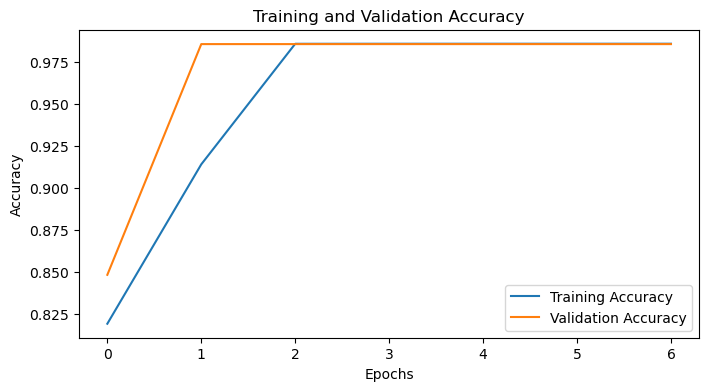

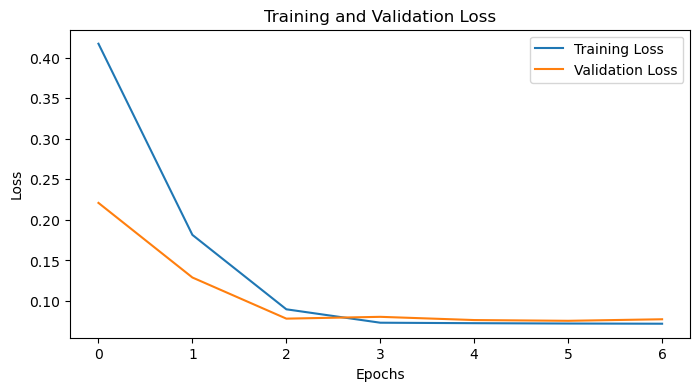

In [197]:
plot_training(history1);

In [198]:
prediction_LSTM = model1.predict(X_test_distLSTM)

3566/3566 [==============================] - 6s 1ms/step


In [199]:
prediction_1_threshold = np.where(prediction_LSTM>0.01,1,0)

In [200]:
print(classification_report(y_test, prediction_1_threshold))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     96571
           1       0.15      1.00      0.27     17537

    accuracy                           0.15    114108
   macro avg       0.08      0.50      0.13    114108
weighted avg       0.02      0.15      0.04    114108



C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


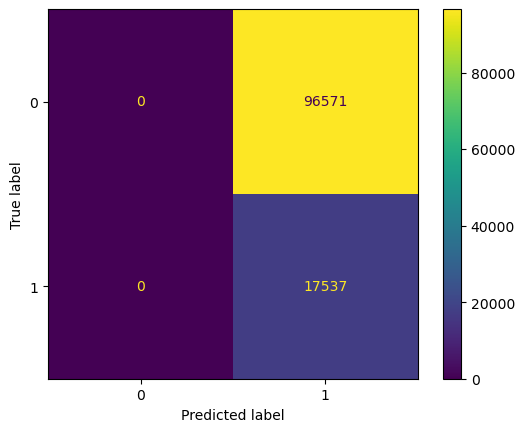

In [201]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction_1_threshold)
ConfusionMatrixDisplay(conf_matrix).plot()

# Dense Model

In [202]:
random_normal_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.0001, seed=51)
model2 = Sequential([
  Input(shape=(X_train_distLSTM.shape[1],)),
  Dense(units=512, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dropout(0.4),
  Dense(units=256, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dropout(0.1),
  Dense(units=128, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dropout(0.1),
  Dense(units=64, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dropout(0.1),
  Dense(units=32, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dense(units=1, activation='sigmoid', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer)
])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               1024      
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

In [203]:
model2.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False)
history2 = model2.fit(X_train_distLSTM,y_train, validation_data=(X_val_distLSTM, y_val), epochs=100, verbose=1, batch_size=100,
                      callbacks=[callback])


# Model evaluation
accuracy1 = model2.evaluate(X_test_distLSTM,y_test)
print(f"Accuracy of model1: {(100*accuracy1[1]):.1f}%")

Epoch 1/100
8559/8559 [==============================] - 36s 4ms/step - loss: 0.0743 - accuracy: 0.9857 - val_loss: 0.0714 - val_accuracy: 0.9858
Epoch 2/100
8559/8559 [==============================] - 33s 4ms/step - loss: 0.0693 - accuracy: 0.9860 - val_loss: 0.0668 - val_accuracy: 0.9858
Epoch 3/100
8559/8559 [==============================] - 33s 4ms/step - loss: 0.0678 - accuracy: 0.9860 - val_loss: 0.0668 - val_accuracy: 0.9858
Epoch 4/100
8559/8559 [==============================] - 36s 4ms/step - loss: 0.0674 - accuracy: 0.9860 - val_loss: 0.0678 - val_accuracy: 0.9858
Epoch 5/100
8559/8559 [==============================] - 34s 4ms/step - loss: 0.0676 - accuracy: 0.9860 - val_loss: 0.0660 - val_accuracy: 0.9858
Epoch 6/100
3566/3566 [==============================] - 4s 1ms/step - loss: 0.0668 - accuracy: 0.9861
Accuracy of model1: 98.6%


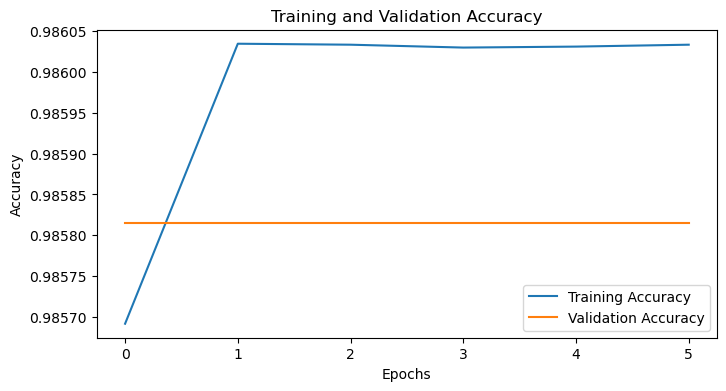

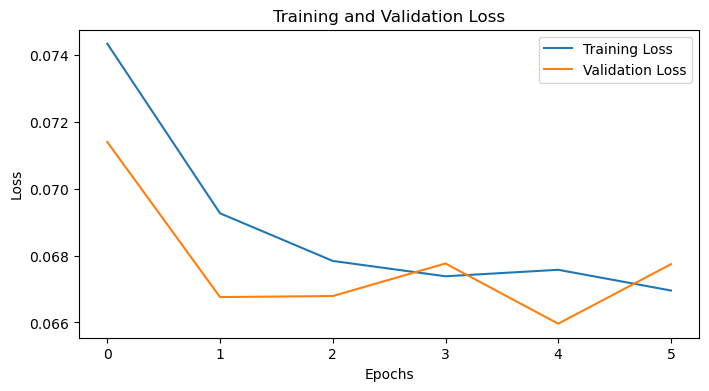

In [204]:
plot_training(history2);

In [205]:
prediction_Dense = model2.predict(X_test_distLSTM)

3566/3566 [==============================] - 4s 1ms/step


In [206]:
prediction_2_threshold = np.where(prediction_Dense>0.01,1,0)

In [207]:
print(classification_report(y_test, prediction_2_threshold))

              precision    recall  f1-score   support

           0       1.00      0.34      0.51     96571
           1       0.22      1.00      0.36     17537

    accuracy                           0.45    114108
   macro avg       0.61      0.67      0.43    114108
weighted avg       0.88      0.45      0.49    114108



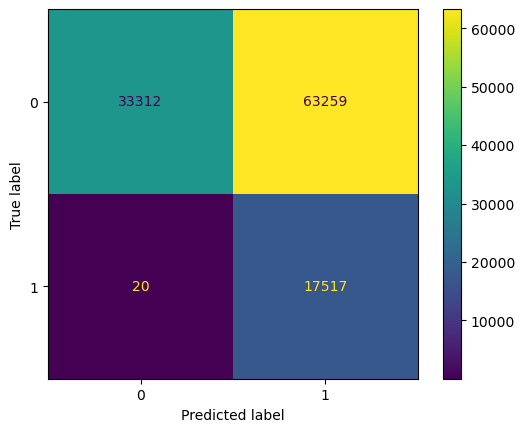

In [208]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction_2_threshold)
ConfusionMatrixDisplay(conf_matrix).plot()